In [1]:

import scanpy as sc
import scarches as sca
import numpy as np

Global seed set to 0


In [2]:
sc.set_figure_params(vector_friendly=True)

In [16]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.dpi"] = 140
font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

In [17]:
def filter_set_scores(scores, adata, filter_v=2.31):
    for k in scores:
        print(k)
        mask = np.abs(scores[k]['bf']) > filter_v
        s = sum(mask)
        if s > 0:
            sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
            enriched_terms = adata.uns['terms'][mask][sort]
            
            print(enriched_terms)
            print(scores[k]['bf'][mask][sort])
            
            for term in enriched_terms:
                adata.obs[term] = adata.obsm['X_cvae'][:, adata.uns['active_terms'] == term]

### Pbmc Kang

In [36]:
adata = sc.read('kang_pbmc_integrated.h5ad')

In [38]:
adata.obs.batch_join = adata.obs.batch_join.astype(str)
adata.obs.batch_join[adata.obs.batch_join=='0'] = 'PBMC (reference)'
adata.obs.batch_join[adata.obs.batch_join=='1'] = 'Kang (query)'

adata.obs['condition_joint'] = adata.obs.condition.astype(str)
adata.obs['condition_joint'][adata.obs['condition_joint'].astype(str)=='nan']='control (reference)'
adata.obs['condition_joint'][adata.obs['condition_joint']=='control']='control (query)'
adata.obs['condition_joint'][adata.obs['condition_joint']=='stimulated']='stimulated (query)'


C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\1640437585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.batch_join[adata.obs.batch_join=='0'] = 'PBMC (reference)'
C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\1640437585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.batch_join[adata.obs.batch_join=='1'] = 'Kang (query)'
C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\1640437585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [39]:
adata.obs['condition_merged'] = adata.obs['condition'].tolist()
adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'
adata.strings_to_categoricals()

C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\3014629654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'


In [40]:
intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020', adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  282 0 0 5 1972
	with hard mask.


In [41]:
adata.uns['active_terms'] = adata.uns['terms'][intr_cvae.model.decoder.nonzero_terms()]

In [42]:
directions = intr_cvae._latent_directions(method="sum")

In [43]:
adata.obsm['X_cvae'] *= directions[intr_cvae.model.decoder.nonzero_terms()]

In [44]:
scores_cond = intr_cvae.latent_enrich('condition_merged', comparison="control", directions=directions, adata=adata)

In [45]:
filter_set_scores(scores_cond, adata, filter_v=0.5)

stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN' 'IMMUNE_SYSTEM'
 'METABOLISM_OF_AMINO_ACIDS_AND_' 'INTERFERON_GAMMA_SIGNALING'
 'NUCLEOTIDE_BINDING_DOMAIN_LEUC' 'GPCR_DOWNSTREAM_SIGNALING'
 'SIGNALING_BY_THE_B_CELL_RECEPT' 'UNFOLDED_PROTEIN_RESPONSE'
 'CLASS_A1_RHODOPSIN_LIKE_RECEPT' 'TOLL_RECEPTOR_CASCADES'
 'METABOLISM_OF_NUCLEOTIDES' 'CYTOKINE_SIGNALING_IN_IMMUNE_S']
[ 4.38  4.1  -1.69  0.79  0.74 -0.59  0.59  0.55 -0.53  0.52  0.52 -0.5
 -0.5 ]


In [46]:
adata.obs['INTERFERON_ALPHA_BETA_SIGNALING'] = adata.obs['INTERFERON_ALPHA_BETA_SIGNALIN']

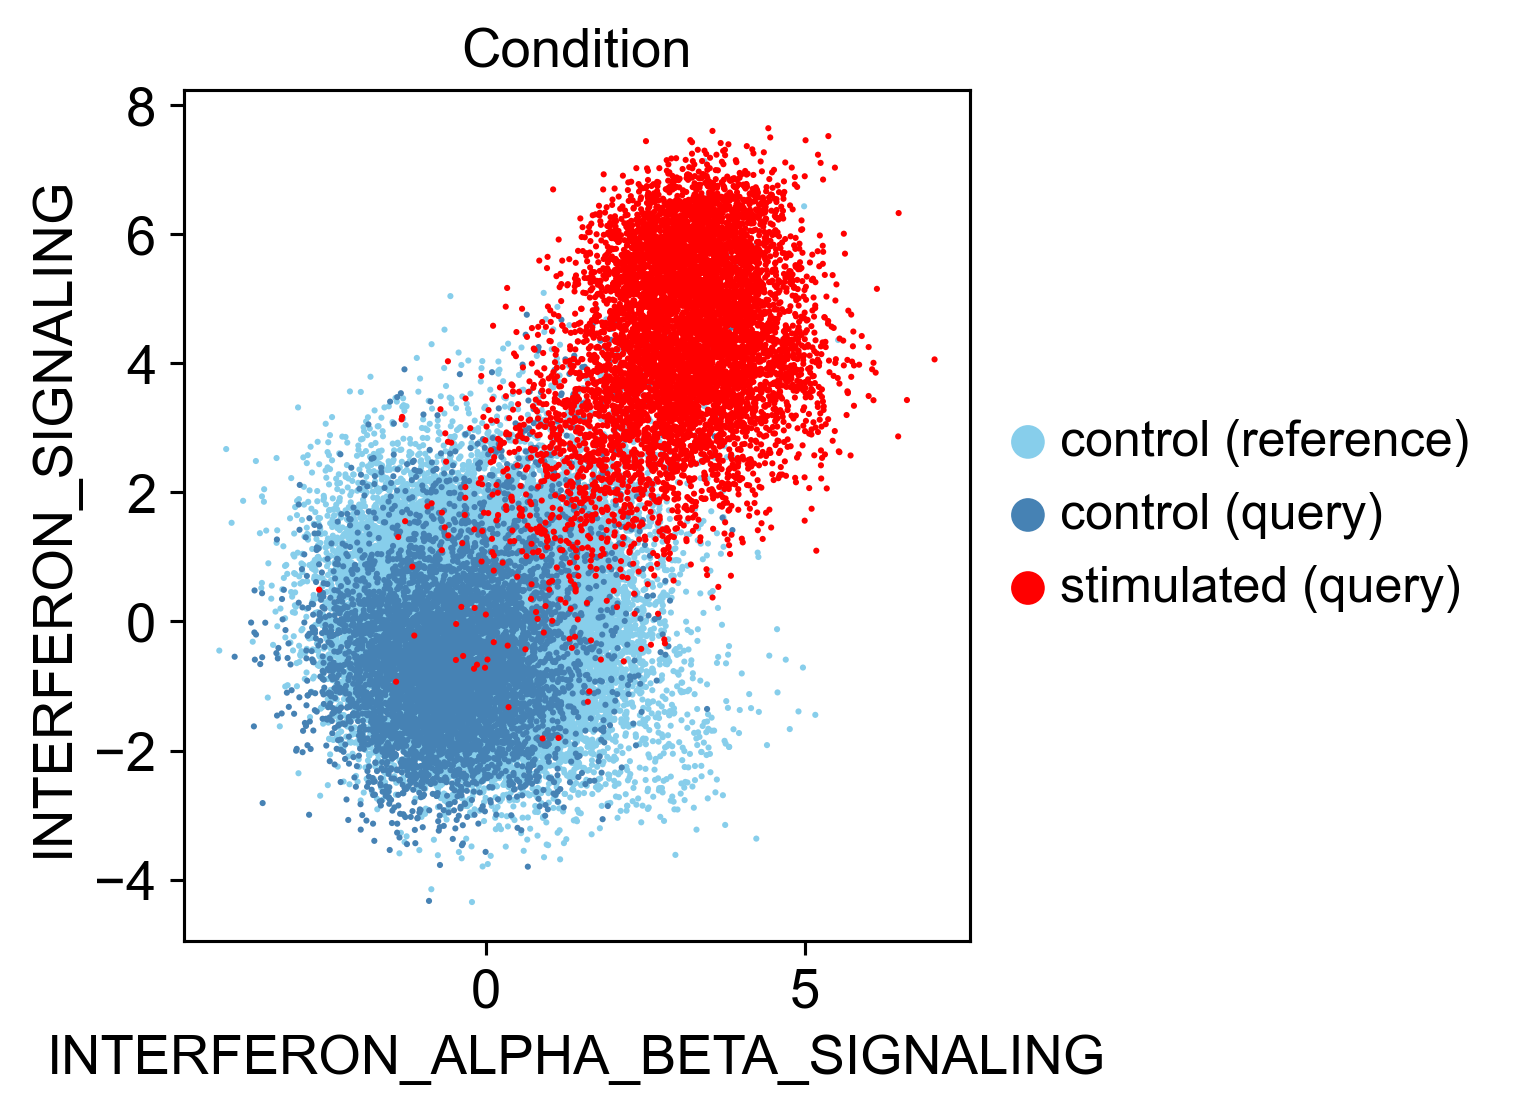

In [47]:
sc.pl.scatter(adata, x='INTERFERON_ALPHA_BETA_SIGNALING', y='INTERFERON_SIGNALING', 
              color='condition_joint', size=10, title='Condition', 
              groups=['control (reference)', 'control (query)', 'stimulated (query)'],
              save='_pbmc_kang_interferon.png', palette=['steelblue', 'skyblue', 'red'])

In [48]:
scores_ct = intr_cvae.latent_enrich('cell_type_joint', directions=directions, n_perm=7000, adata=adata)

In [49]:
filter_set_scores(scores_ct, adata, filter_v=1.5)

CD16+ Monocytes
['PLATELET_ACTIVATION_SIGNALING_' 'METABOLISM_OF_AMINO_ACIDS_AND_'
 'TRANSMEMBRANE_TRANSPORT_OF_SMA' 'SIGNALING_BY_GPCR'
 'METABOLISM_OF_NUCLEOTIDES' 'IMMUNOREGULATORY_INTERACTIONS_'
 'IMMUNE_SYSTEM' 'METABOLISM_OF_PROTEINS' 'GPCR_DOWNSTREAM_SIGNALING'
 'CELL_CYCLE_MITOTIC']
[-2.74  2.73  2.19 -2.12 -2.01  1.81 -1.8  -1.79  1.68 -1.51]
CD4+ T cells
['ADAPTIVE_IMMUNE_SYSTEM' 'METABOLISM_OF_PROTEINS' 'SIGNALING_BY_GPCR']
[2.03 1.96 1.64]
CD14+ Monocytes
['INNATE_IMMUNE_SYSTEM' 'DEVELOPMENTAL_BIOLOGY'
 'METABOLISM_OF_LIPIDS_AND_LIPOP' 'TRANSMEMBRANE_TRANSPORT_OF_SMA'
 'SIGNALING_BY_GPCR' 'AMYLOIDS' 'METABOLISM_OF_CARBOHYDRATES'
 'ADAPTIVE_IMMUNE_SYSTEM' 'CYTOKINE_SIGNALING_IN_IMMUNE_S'
 'METABOLISM_OF_RNA' 'METABOLISM_OF_NUCLEOTIDES' 'METABOLISM_OF_PROTEINS'
 'HEMOSTASIS' 'BIOLOGICAL_OXIDATIONS' 'METABOLISM_OF_AMINO_ACIDS_AND_'
 'PLATELET_ACTIVATION_SIGNALING_' 'CELL_CYCLE_MITOTIC'
 'GENERIC_TRANSCRIPTION_PATHWAY' 'MEIOSIS' 'MEMBRANE_TRAFFICKING']
[ 3.96 -3.69  3.43  3.33 

In [50]:
for cat in adata.obs.cell_type_joint[adata.obs.batch_join == 'Kang (query)'].unique():
    print(cat)
    adata_ct = adata[adata.obs.cell_type_joint == cat]
    scores_c_ct = intr_cvae.latent_enrich('condition_merged', comparison="control", directions=directions, adata=adata_ct)
    filter_set_scores(scores_c_ct, adata)

CD14+ Monocytes
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN'
 'CYTOKINE_SIGNALING_IN_IMMUNE_S' 'GPCR_DOWNSTREAM_SIGNALING'
 'IMMUNE_SYSTEM']
[ 8.01  4.78 -3.07  2.79 -2.65]
CD4+ T cells
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN']
[4.36 3.58]
T
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN']
[4.21 3.39]
CD8+ T cells
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN' 'IMMUNE_SYSTEM']
[ 4.08  3.34 -2.36]
B
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN']
[4.82 3.79]
DC
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN' 'PROTEIN_FOLDING'
 'IMMUNE_SYSTEM']
[27.63  5.92  3.09 -2.65]
CD16+ Monocytes
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN'
 'CYTOKINE_SIGNALING_IN_IMMUNE_S']
[ 6.91  6.06 -2.82]
NK cells
stimulated
['INTERFERON_SIGNALING' 'INTERFERON_ALPHA_BETA_SIGNALIN' 'IMMUNE_SYSTEM']
[ 3.76  3.62 -2.42]


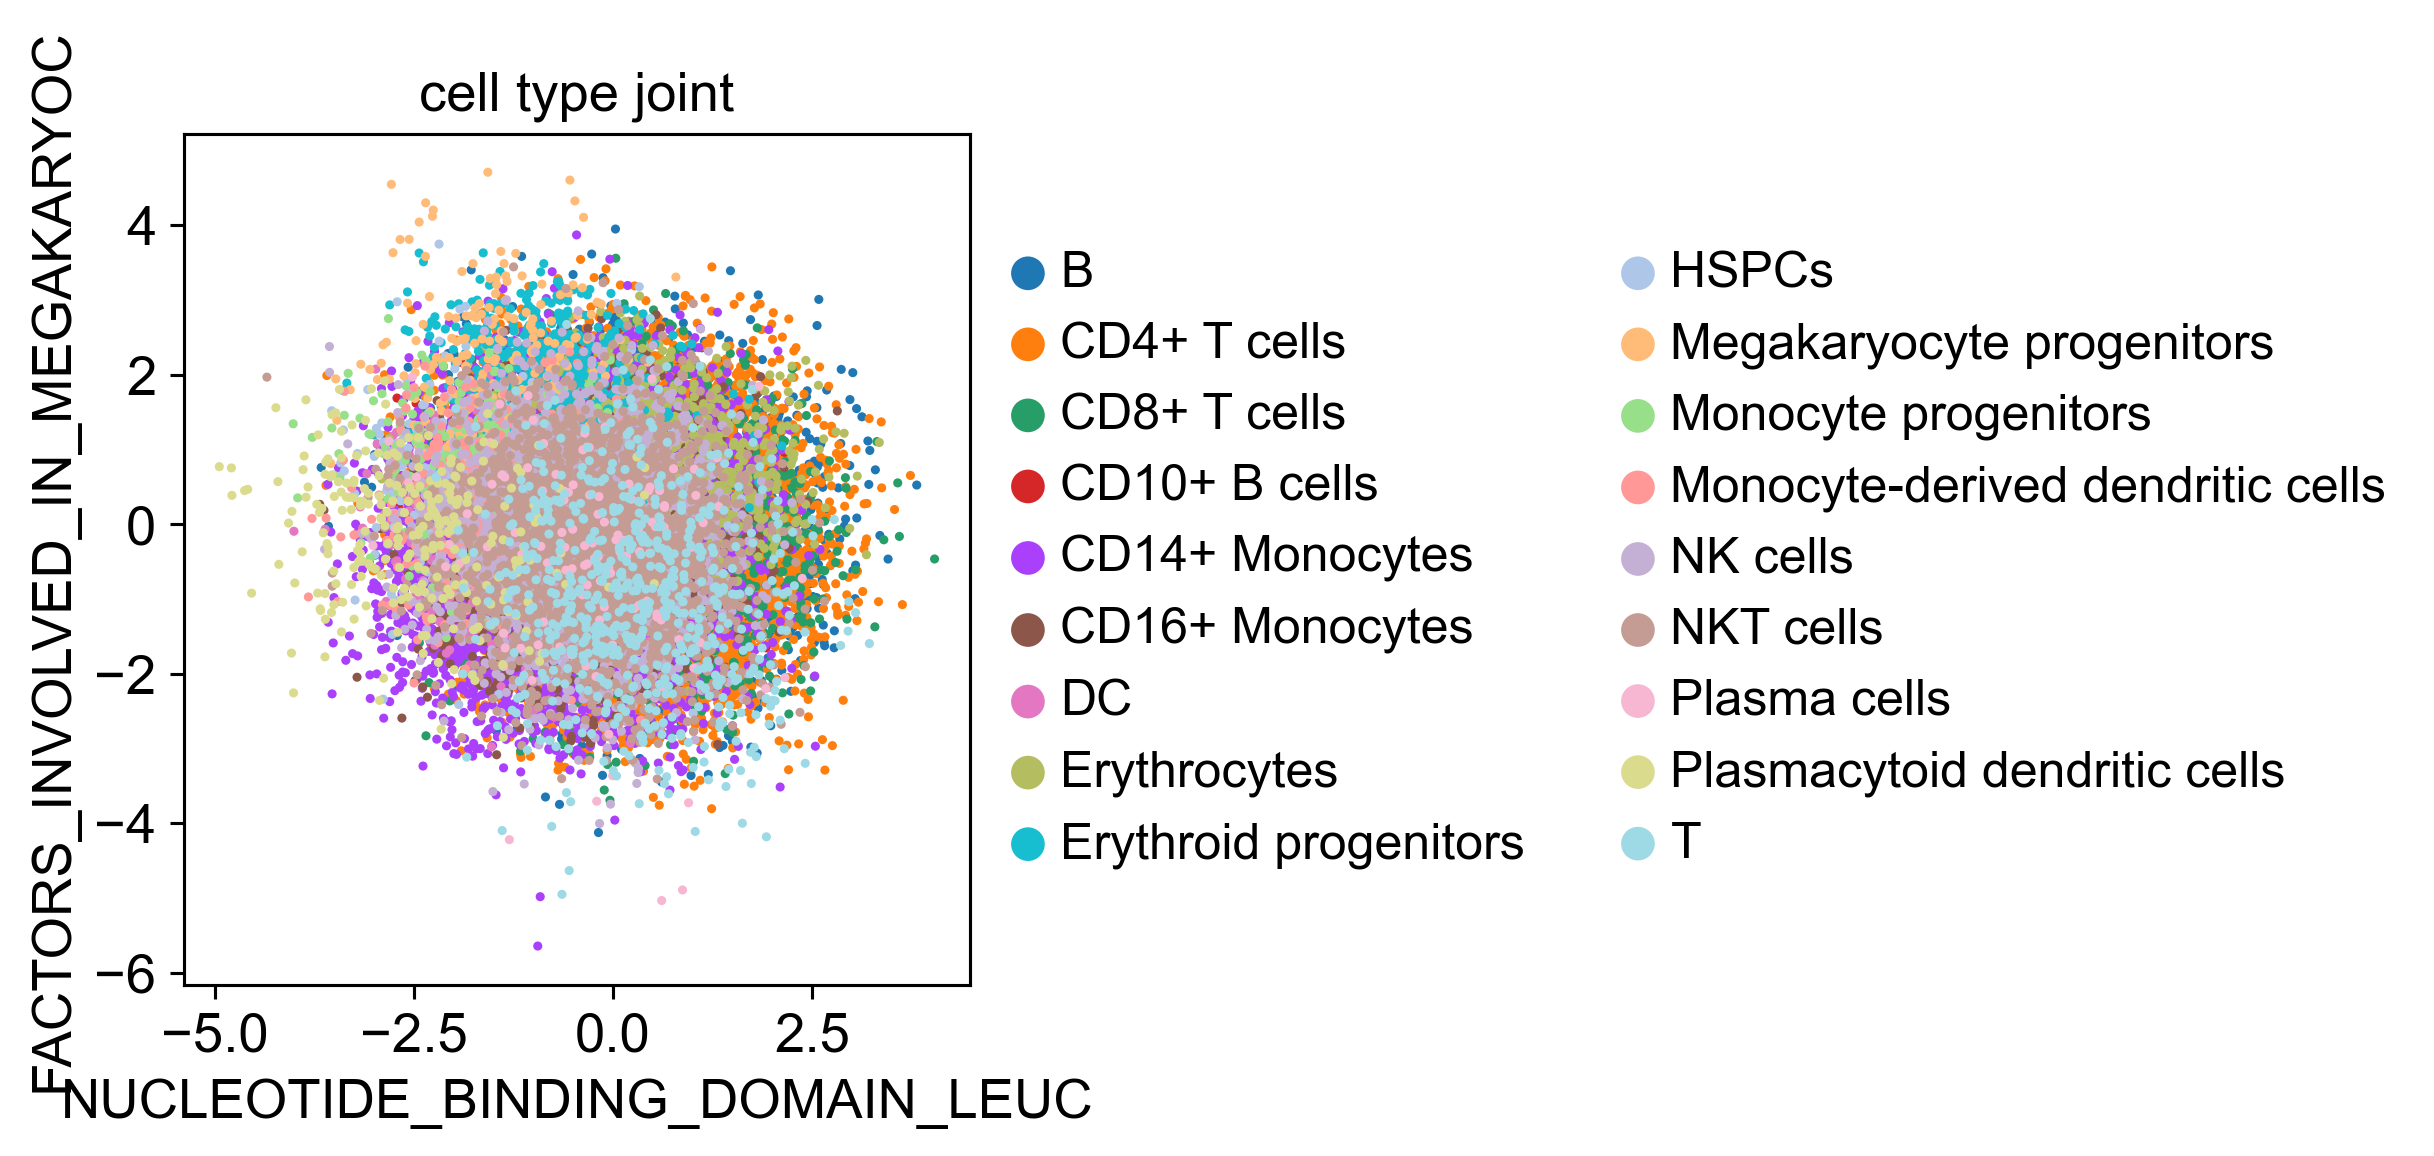

In [51]:
sc.pl.scatter(adata, x='NUCLEOTIDE_BINDING_DOMAIN_LEUC', y='FACTORS_INVOLVED_IN_MEGAKARYOC', 
              color='cell_type_joint', size=22)

In [52]:
adata.obs.cell_type_joint[adata.obs.batch_join == 'Kang (query)'].unique()

['CD14+ Monocytes', 'CD4+ T cells', 'T', 'CD8+ T cells', 'B', 'DC', 'CD16+ Monocytes', 'NK cells']
Categories (8, object): ['CD14+ Monocytes', 'CD4+ T cells', 'T', 'CD8+ T cells', 'B', 'DC', 'CD16+ Monocytes', 'NK cells']

In [53]:
adata.obs.cell_type_joint.cat.categories

Index(['B', 'CD4+ T cells', 'CD8+ T cells', 'CD10+ B cells', 'CD14+ Monocytes',
       'CD16+ Monocytes', 'DC', 'Erythrocytes', 'Erythroid progenitors',
       'HSPCs', 'Megakaryocyte progenitors', 'Monocyte progenitors',
       'Monocyte-derived dendritic cells', 'NK cells', 'NKT cells',
       'Plasma cells', 'Plasmacytoid dendritic cells', 'T'],
      dtype='object')

### Figure

In [54]:
matplotlib.rcParams['axes.labelsize'] = 15.7

In [55]:
condition = 'condition_joint'
condition_loc = 'lower left'
groups = ['control (reference)', 'control (query)', 'stimulated (query)']
size = 10
palette=['steelblue', 'skyblue', 'red']

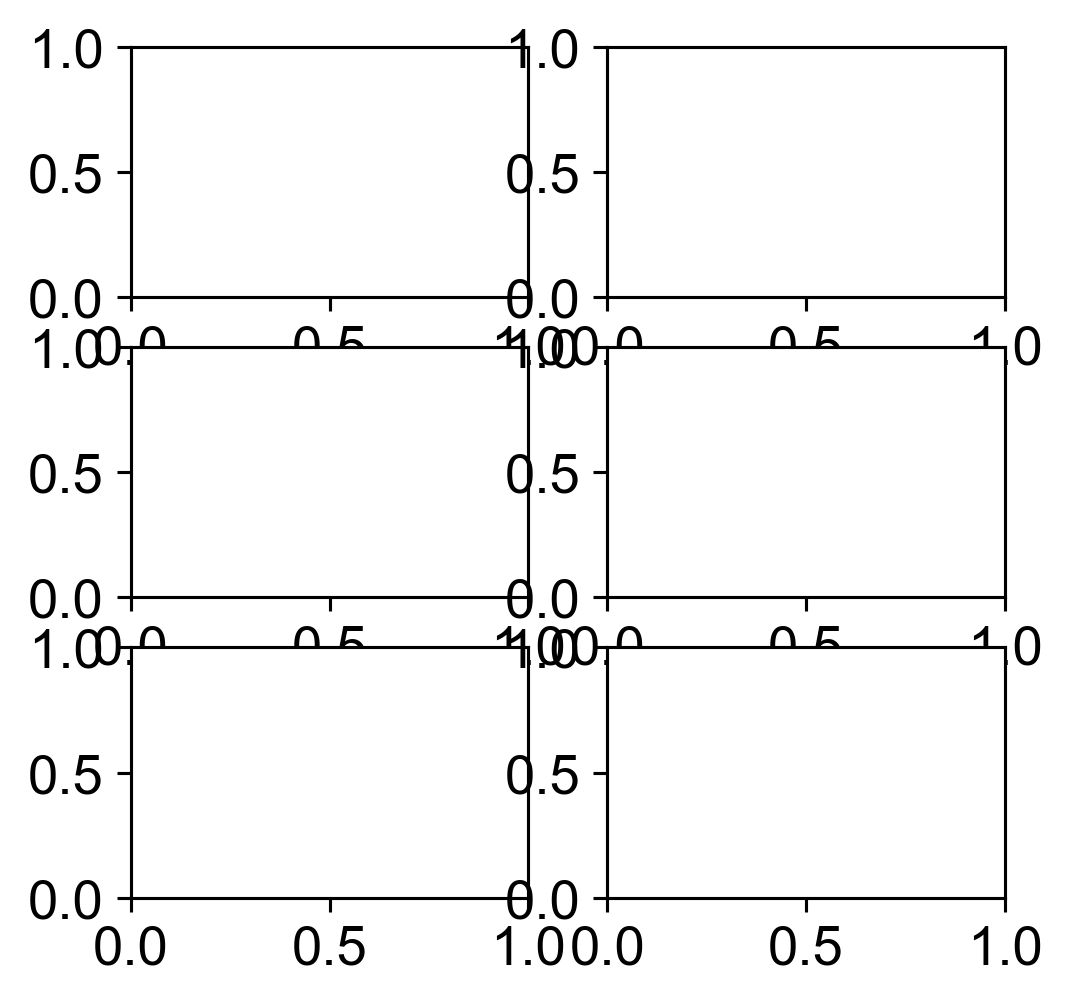

In [99]:
fig, axs = plt.subplots(3, 2)

In [100]:
adata.obs['MHC_CLASS_II_ANTIGEN_PRESENTATION'] = adata.obs['MHC_CLASS_II_ANTIGEN_PRESENTAT']
adata.obs['SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR'] = adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT']

In [101]:
cell_mask = ~np.in1d(adata.obs['cell_type_joint'],['B', 'CD10+ B cells'])

In [102]:
adata.obs['cell_type_b'] = adata.obs['cell_type_joint'].astype('O')
adata.obs['cell_type_b'][cell_mask] = 'others'

C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\3739272784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_b'][cell_mask] = 'others'


In [103]:
sc.pl.scatter(adata, x='MHC_CLASS_II_ANTIGEN_PRESENTATION', y='SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 
              color='cell_type_b',ax=axs)

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

In [104]:
for i, cat in enumerate(adata.obs['cell_type_b'].cat.categories):
    if cat=='others':
        adata.uns['cell_type_b_colors'][i] = 'gray'
    else:
        idx = adata.obs['cell_type_joint'].cat.categories == cat
        adata.uns['cell_type_b_colors'][i] = np.array(adata.uns['cell_type_joint_colors'])[idx][0]

In [105]:
sc.pl.scatter(adata, x='SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', y='MHC_CLASS_II_ANTIGEN_PRESENTATION', 
              color='cell_type_b', size=size, title='B cells', legend_loc='lower left', ax=axs[0,0],
              groups=['others', 'B', 'CD10+ B cells'])

In [106]:
sc.pl.scatter(adata, x='SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', y='INTERFERON_SIGNALING', 
              color='cell_type_b', size=size, title='B cells', legend_loc='lower left', ax=axs[1,0],
              groups=['others', 'B', 'CD10+ B cells'])

In [107]:
sc.pl.scatter(adata, x='SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', y='INTERFERON_SIGNALING', 
              color=condition, size=size, title='B cells condition', legend_loc=condition_loc, groups=groups, ax=axs[2,0], 
              palette=palette)

In [117]:
fig.set_size_inches(10, 11)

In [118]:
fig.tight_layout() 

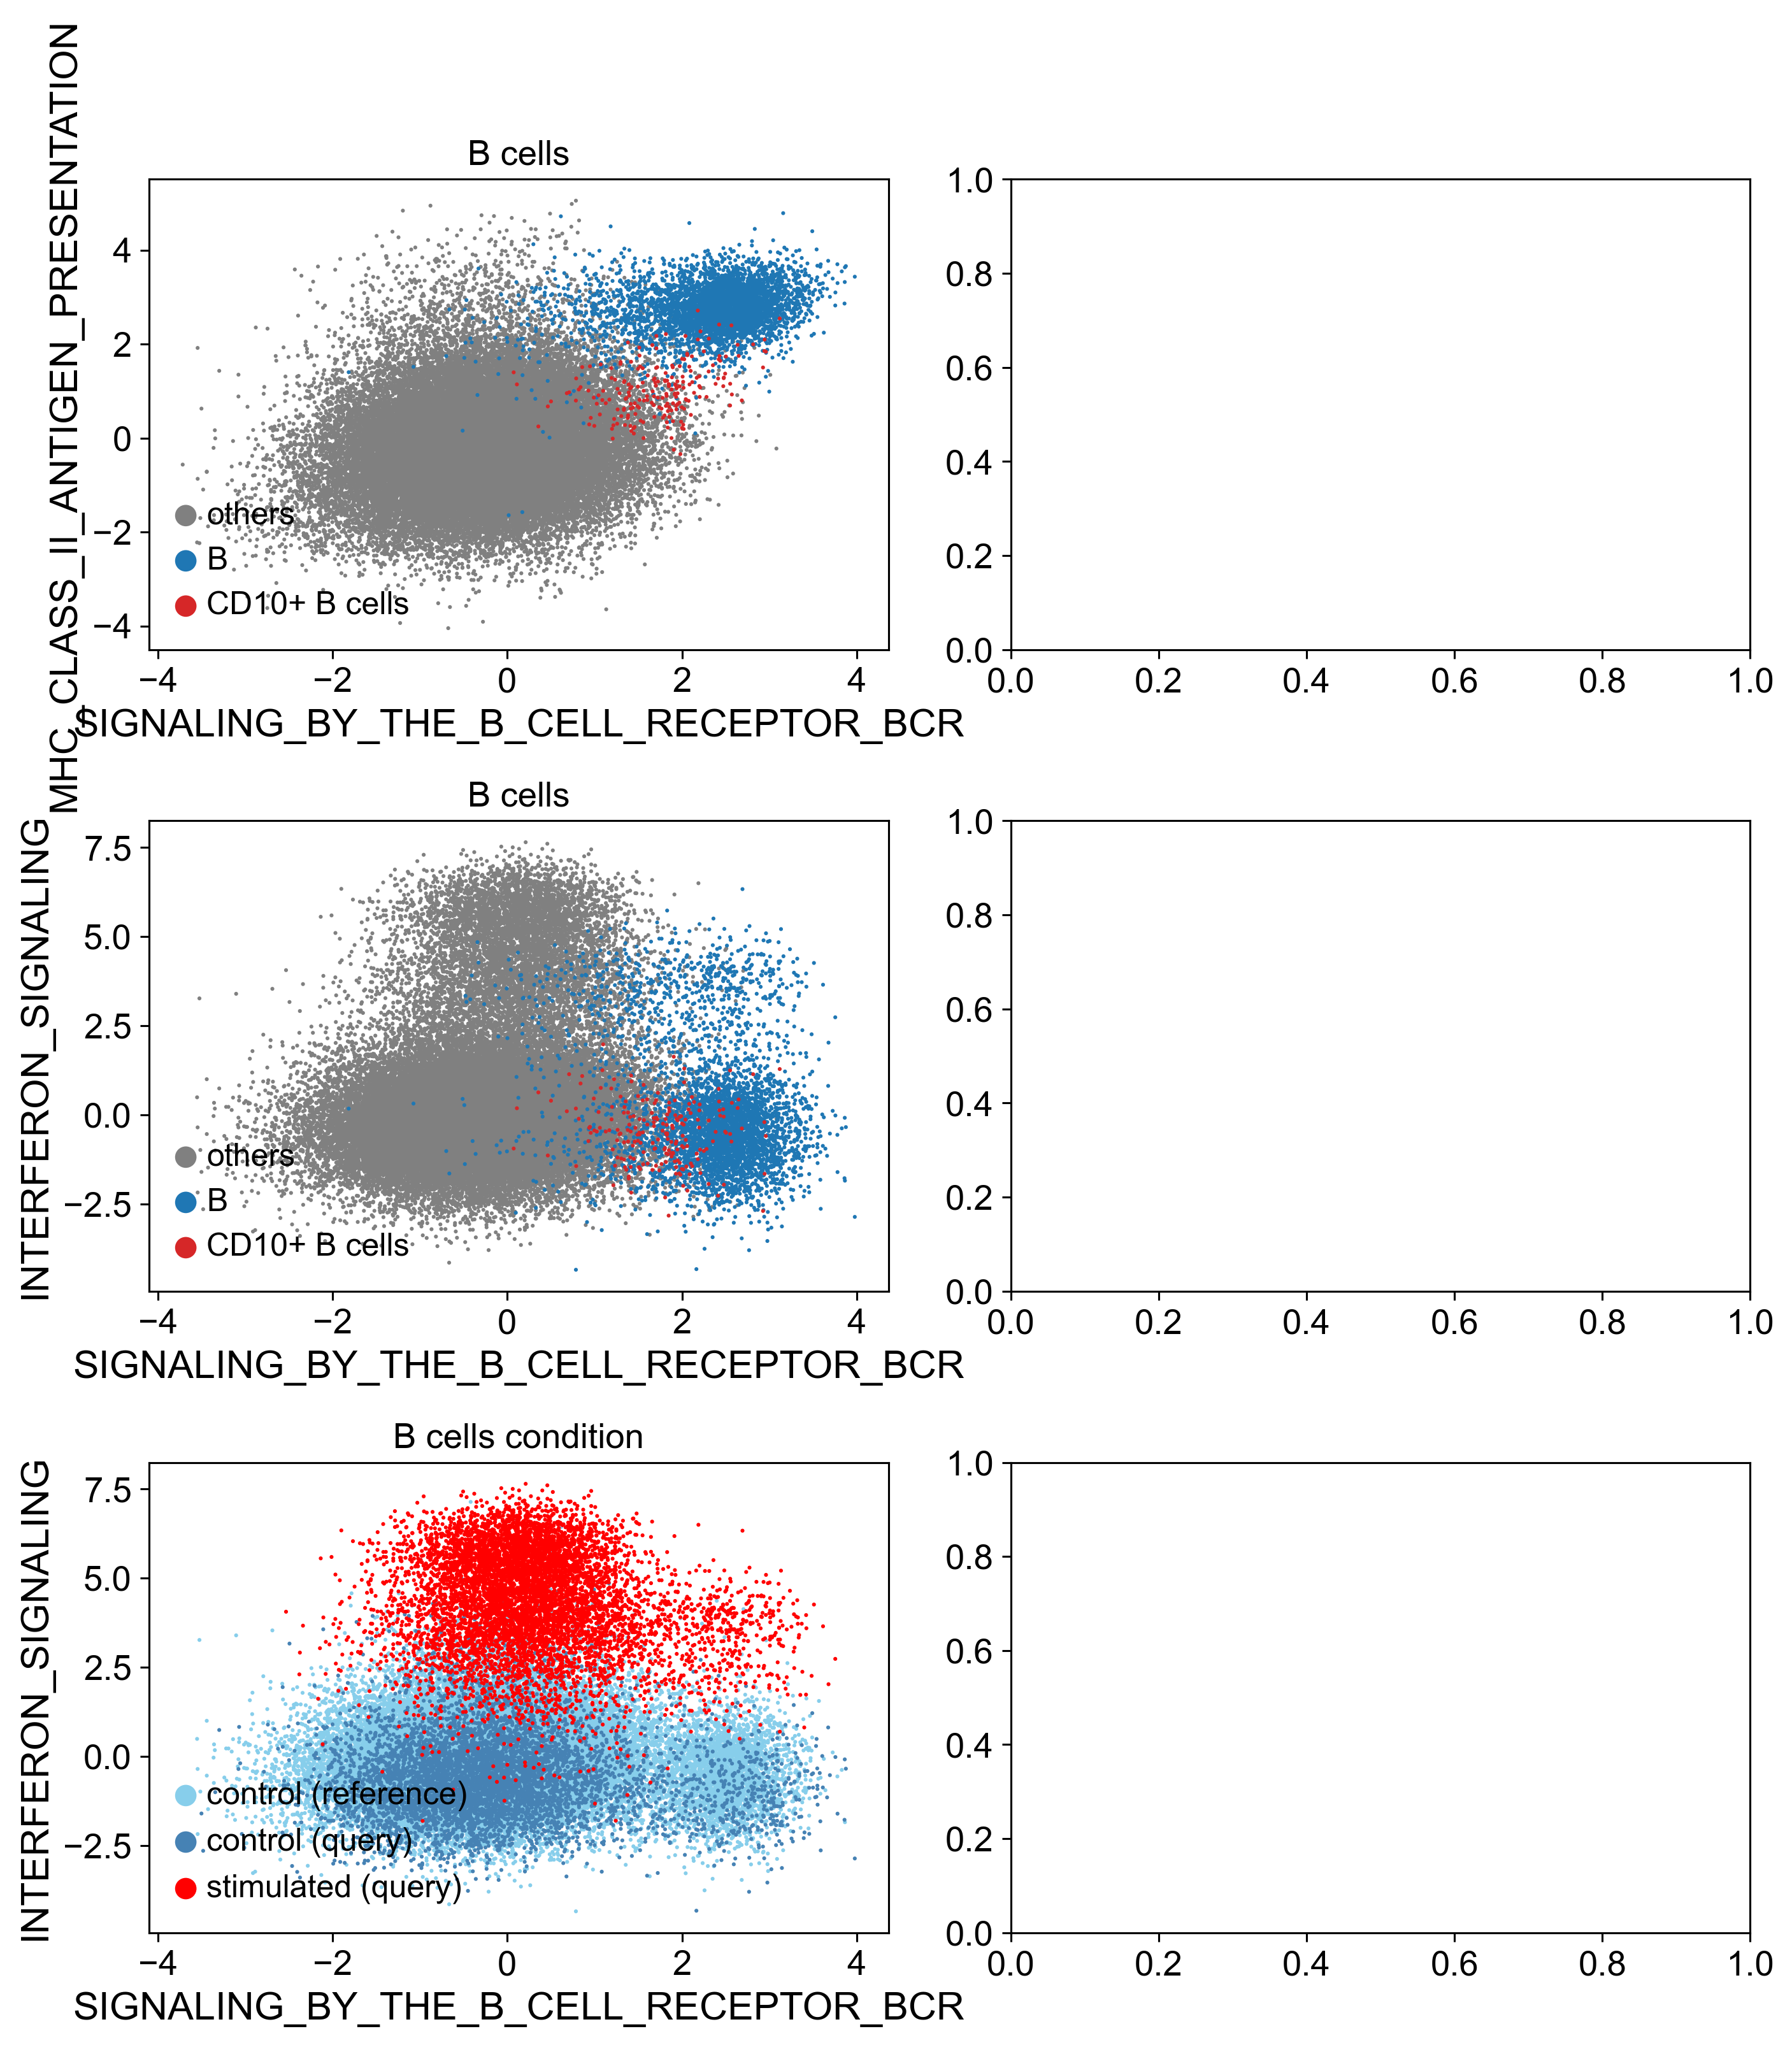

In [119]:
fig

In [120]:
adata.obs['METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS'] = adata.obs['METABOLISM_OF_LIPIDS_AND_LIPOP']
adata.obs['METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES'] = adata.obs['METABOLISM_OF_AMINO_ACIDS_AND_']
adata.obs['IMMUNOREGULATORY_INTERACTIONS_LYMPHOID_-_NON_LYMPHOID_CELL'] = adata.obs['IMMUNOREGULATORY_INTERACTIONS_']
adata.obs['PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION'] = adata.obs['PLATELET_ACTIVATION_SIGNALING_']

In [121]:
cell_mask = ~np.in1d(adata.obs['cell_type_joint'],['CD16+ Monocytes', 'CD14+ Monocytes'])

In [122]:
adata.obs['cell_type_m'] = adata.obs['cell_type_joint'].astype('O')
adata.obs['cell_type_m'][cell_mask] = 'others'

C:\Users\Mick\AppData\Local\Temp\ipykernel_4732\4095816734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_m'][cell_mask] = 'others'


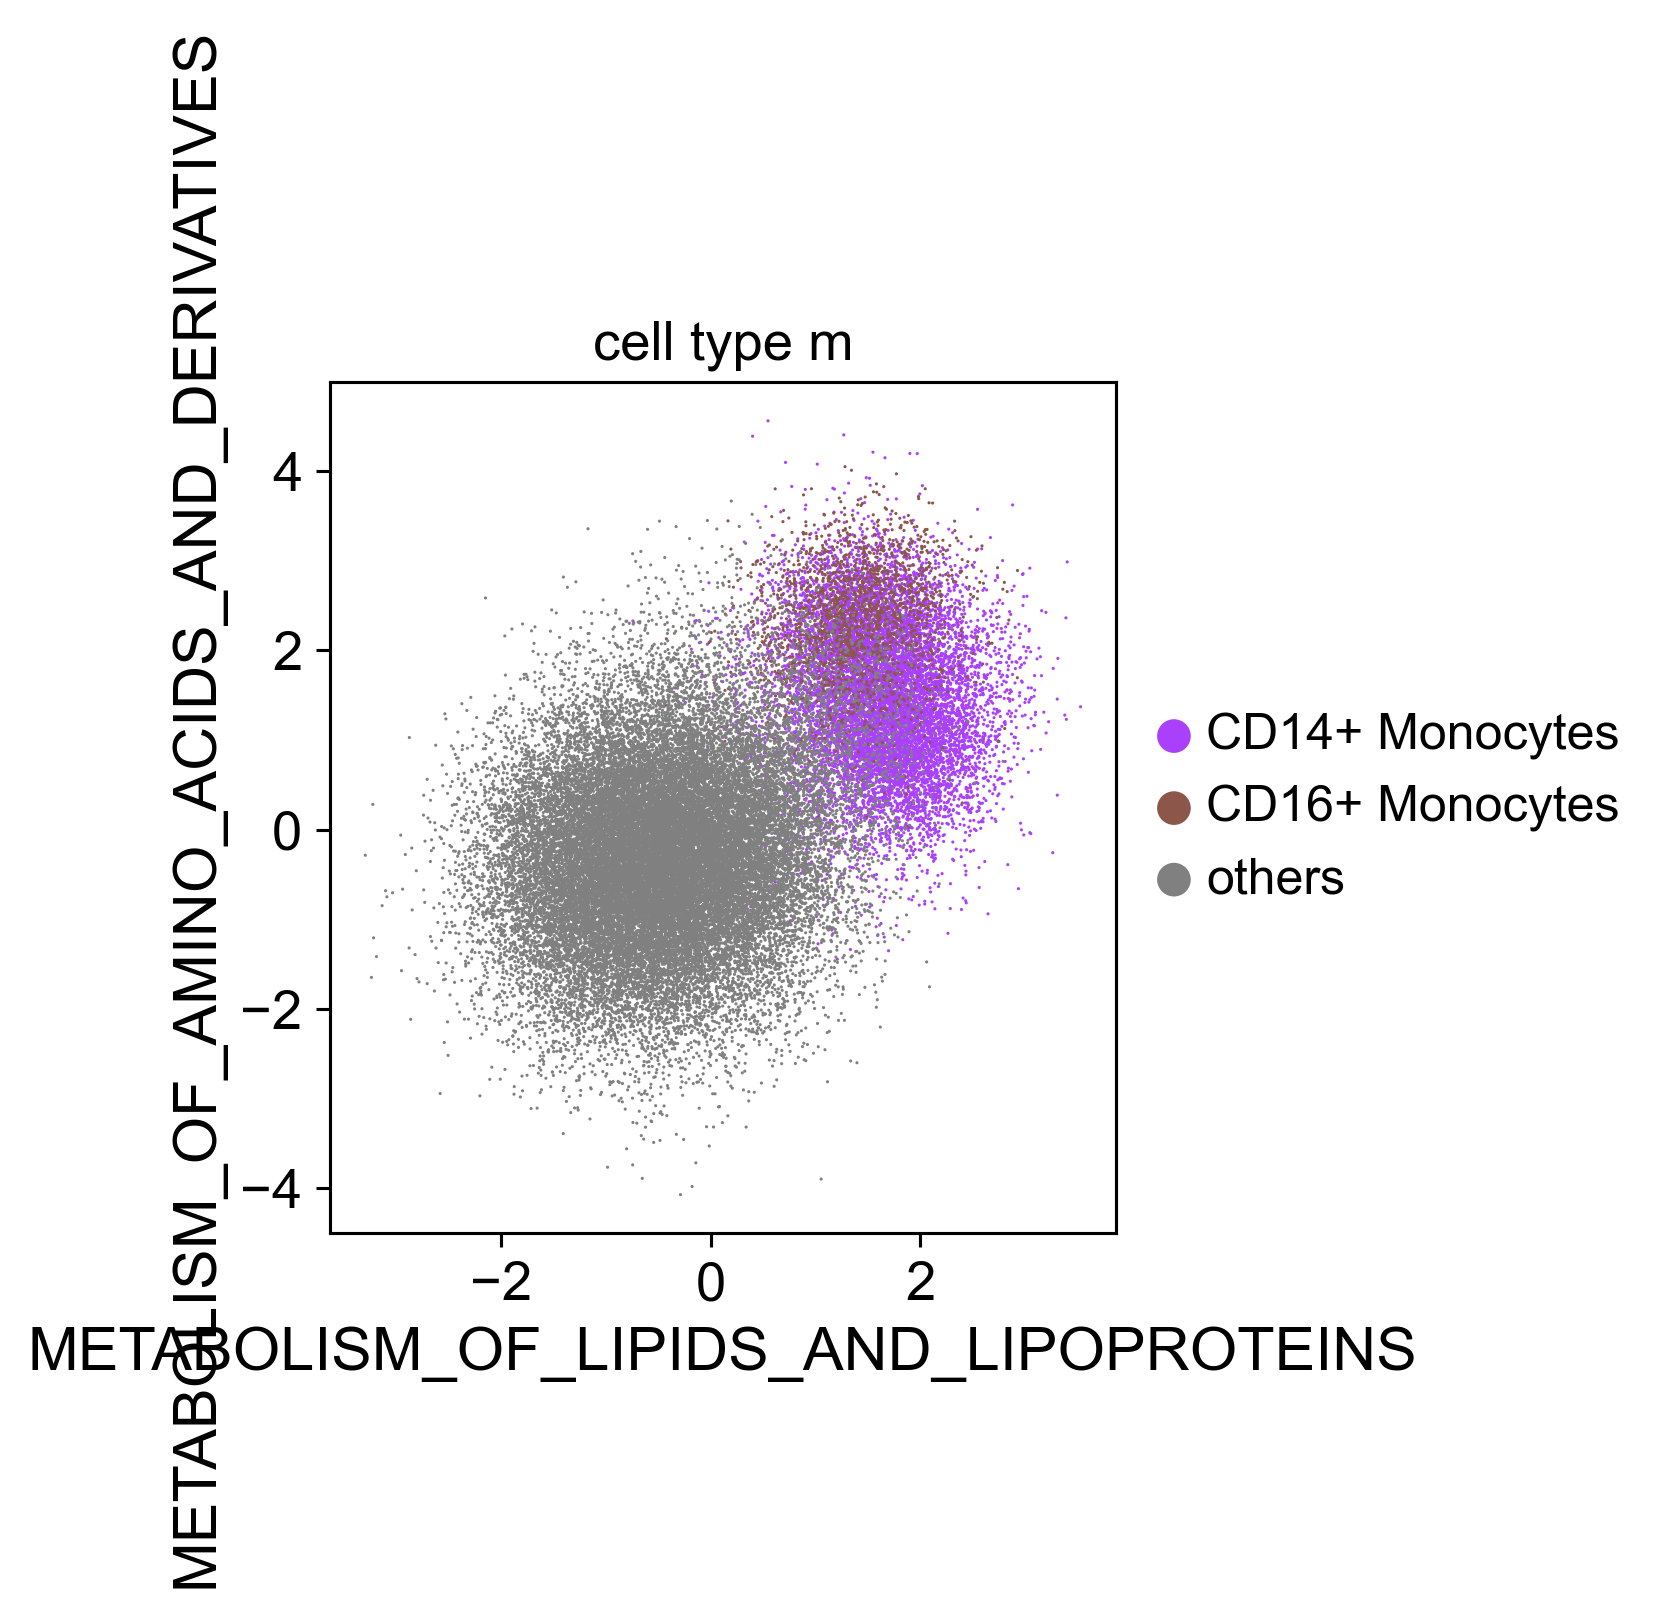

In [123]:
sc.pl.scatter(adata, x='METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', y='METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES', 
              color='cell_type_m')

In [72]:
for i, cat in enumerate(adata.obs['cell_type_m'].cat.categories):
    if cat=='others':
        adata.uns['cell_type_m_colors'][i] = 'gray'
    else:
        idx = adata.obs['cell_type_joint'].cat.categories == cat
        adata.uns['cell_type_m_colors'][i] = np.array(adata.uns['cell_type_joint_colors'])[idx][0]

In [124]:
sc.pl.scatter(adata, x='METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', y='PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION', 
              color='cell_type_m', size=size, title='Monocytes', legend_loc='lower left', ax=axs[0,1],
              groups=['others', 'CD14+ Monocytes', 'CD16+ Monocytes'])

In [125]:
sc.pl.scatter(adata, x='METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', y='INTERFERON_SIGNALING', 
              color='cell_type_m', size=size, title='Monocytes', legend_loc='lower left', ax=axs[1,1],
              groups=['others', 'CD14+ Monocytes', 'CD16+ Monocytes'])

In [127]:
sc.pl.scatter(adata, x='METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', y='INTERFERON_SIGNALING', 
              color=condition, size=size, title='Monocytes condition', legend_loc=condition_loc, groups=groups, ax=axs[2,1],
              palette=palette)

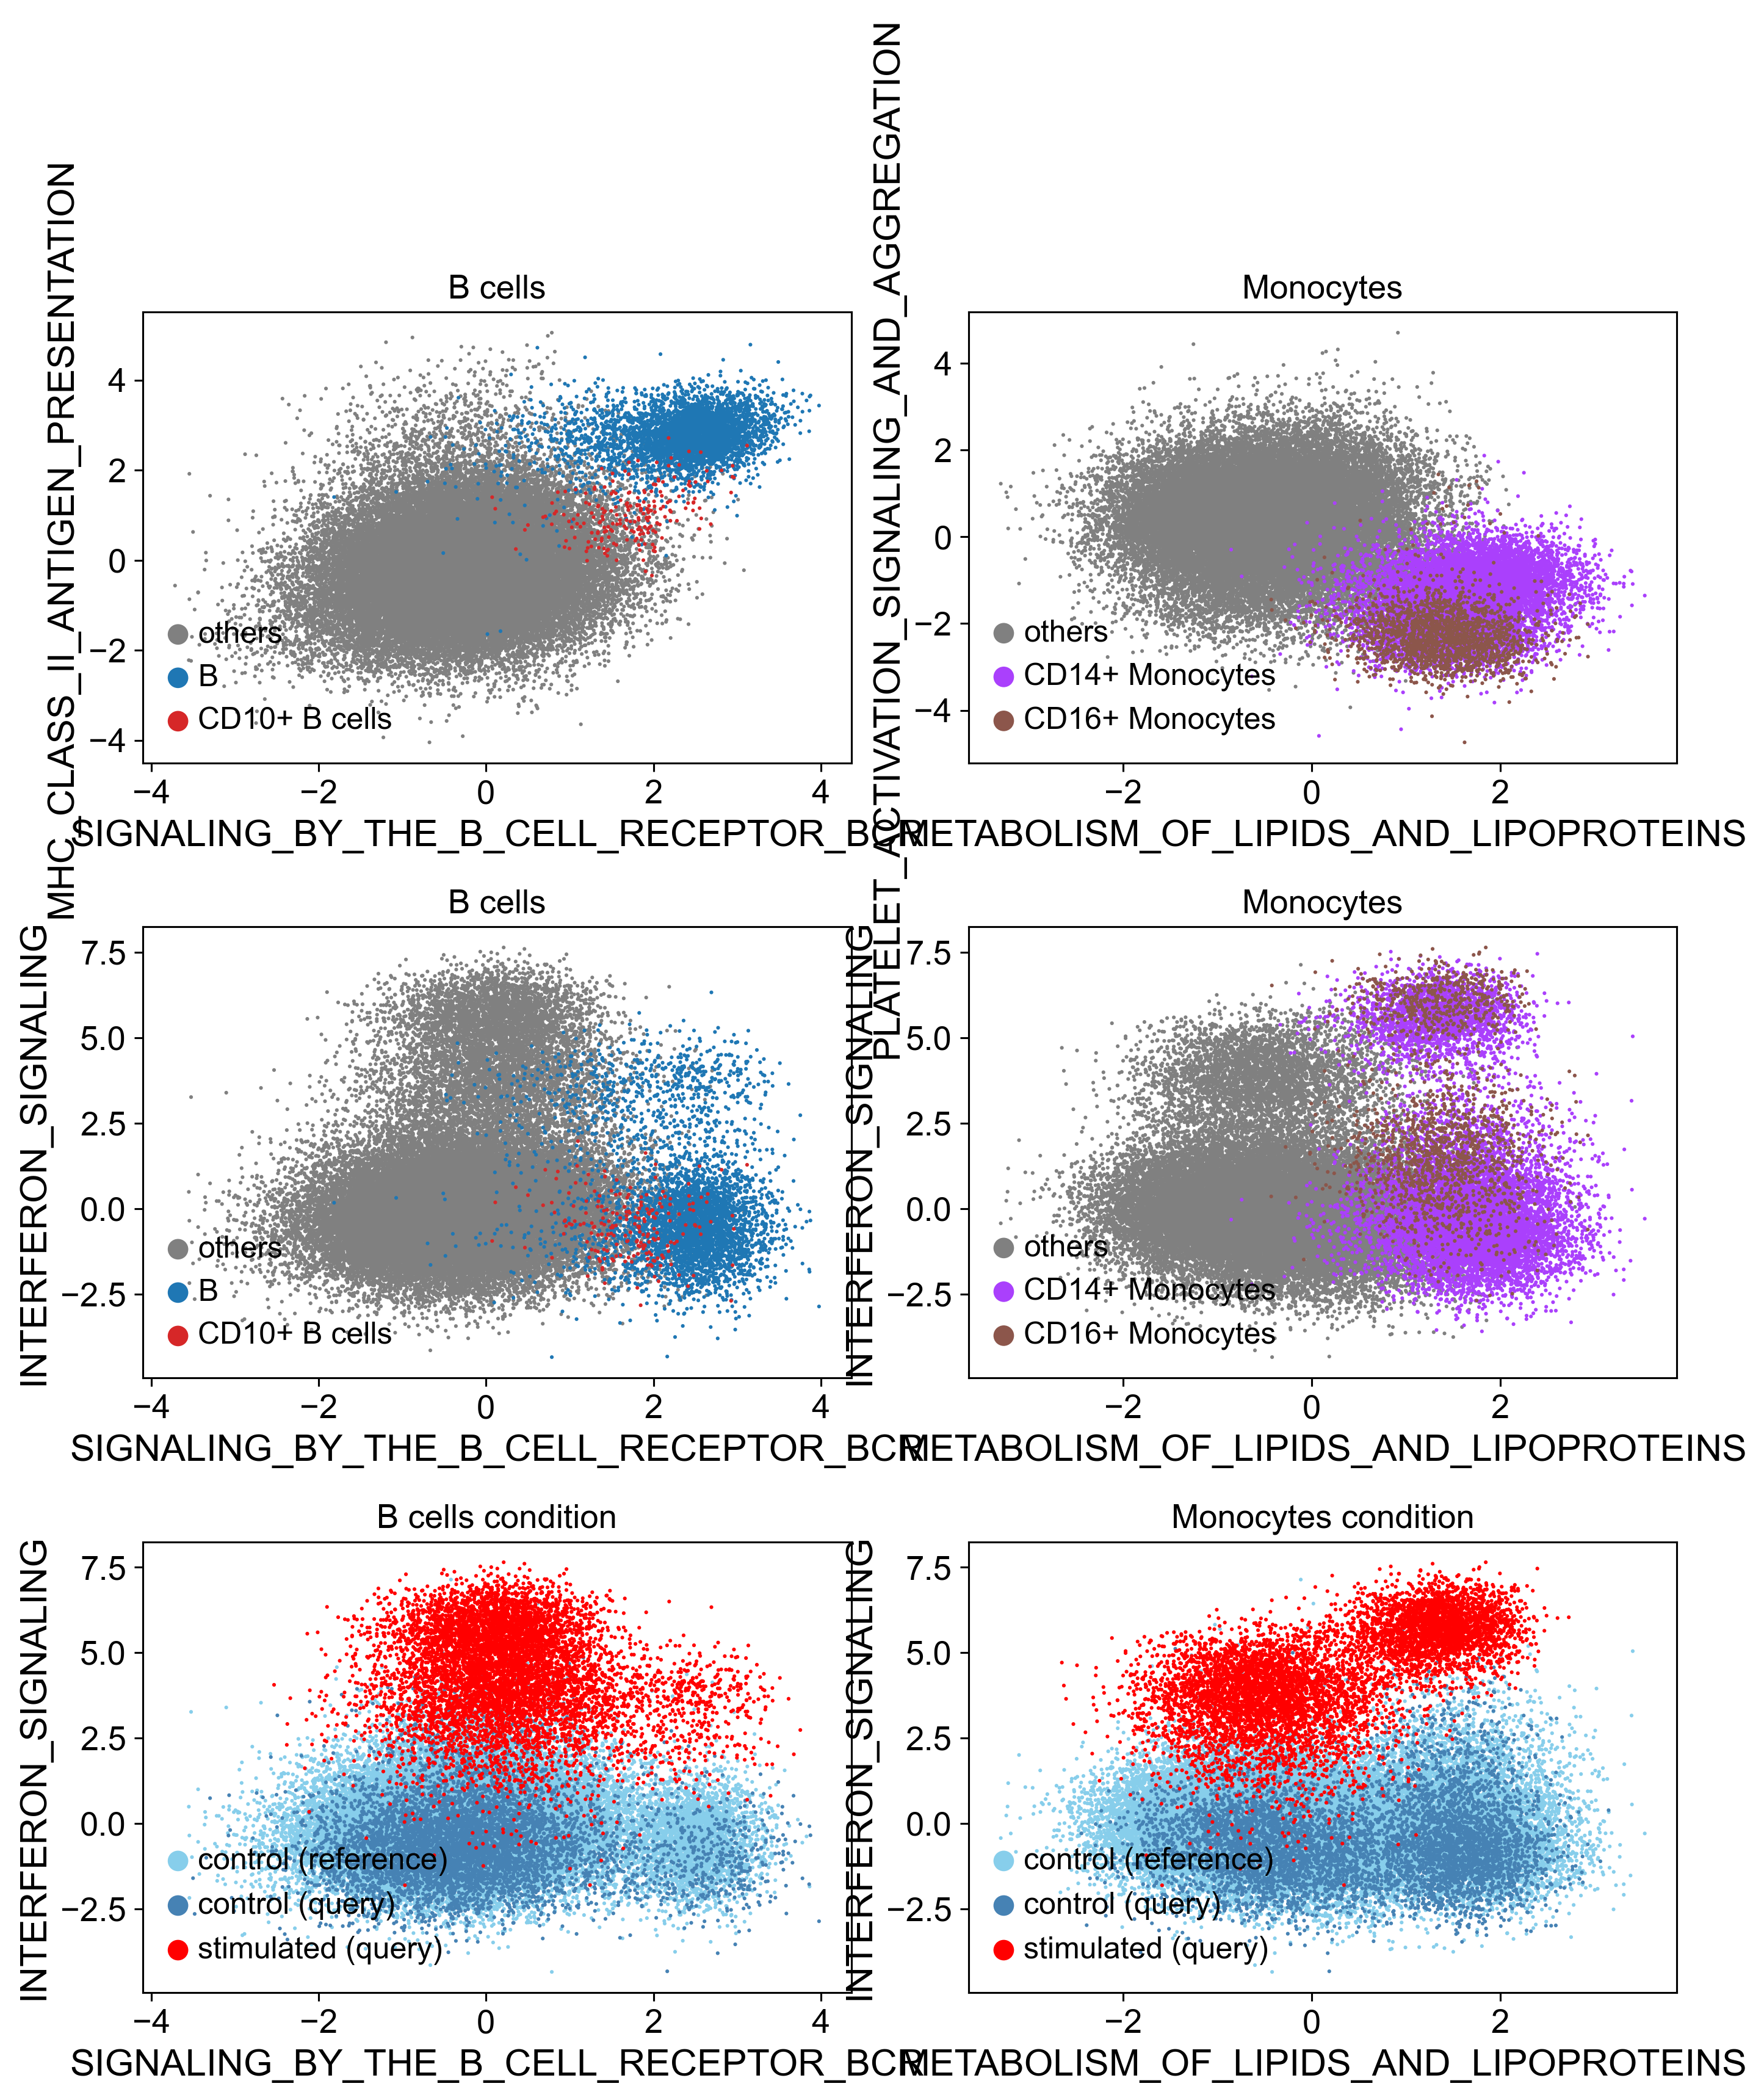

In [128]:
fig

In [ ]:
cell_mask = ~np.in1d(adata.obs['cell_type_joint'],['Monocyte-derived dendritic cells', 'DC'])

In [ ]:
adata.obs['cell_type_d'] = adata.obs['cell_type_joint'].astype('O')
adata.obs['cell_type_d'][cell_mask] = 'others'

In [ ]:
sc.pl.scatter(adata, x='MHC_CLASS_II_ANTIGEN_PRESENTATION', y='AMYLOIDS', color='cell_type_d')

In [ ]:
for i, cat in enumerate(adata.obs['cell_type_d'].cat.categories):
    if cat=='others':
        adata.uns['cell_type_d_colors'][i] = 'gray'
    else:
        idx = adata.obs['cell_type_joint'].cat.categories == cat
        adata.uns['cell_type_d_colors'][i] = np.array(adata.uns['cell_type_joint_colors'])[idx][0]

In [ ]:
sc.pl.scatter(adata, x='MHC_CLASS_II_ANTIGEN_PRESENTATION', y='AMYLOIDS', 
              color='cell_type_d', size=size, title='Dendritic cells', legend_loc='lower right', ax=axs[2,0],
              groups=['others', 'DC', 'Monocyte-derived dendritic cells'])

In [ ]:
sc.pl.scatter(adata, x='MHC_CLASS_II_ANTIGEN_PRESENTATION', y='INTERFERON_SIGNALING', 
              color='cell_type_d', size=size, title='Dendritic cells', legend_loc='lower right', ax=axs[2,1],
              groups=['others', 'DC', 'Monocyte-derived dendritic cells'])

In [ ]:
sc.pl.scatter(adata, x='MHC_CLASS_II_ANTIGEN_PRESENTATION', y='INTERFERON_SIGNALING', 
              color=condition, size=size, title='Dendritic cells condition', legend_loc=condition_loc, groups=groups, ax=axs[2,2],
              palette=palette)

In [ ]:
fig

In [ ]:
cell_mask = ~np.in1d(adata.obs['cell_type_joint'],['CD4+ T cells', 'CD8+ T cells', 'T', 'NKT cells'])

In [ ]:
adata.obs['cell_type_t'] = adata.obs['cell_type_joint'].astype('O')
adata.obs['cell_type_t'][cell_mask] = 'others'

In [ ]:
sc.pl.scatter(adata, x='ADAPTIVE_IMMUNE_SYSTEM', y='SIGNALING_BY_GPCR', 
              color='cell_type_t', groups=['others', 'CD4+ T cells', 'NKT cells', 'CD8+ T cells', 'T'])

In [ ]:
for i, cat in enumerate(adata.obs['cell_type_t'].cat.categories):
    if cat=='others':
        adata.uns['cell_type_t_colors'][i] = 'gray'
    else:
        idx = adata.obs['cell_type_joint'].cat.categories == cat
        adata.uns['cell_type_t_colors'][i] = np.array(adata.uns['cell_type_joint_colors'])[idx][0]

In [ ]:
sc.pl.scatter(adata, x='IMMUNE_SYSTEM', y='SIGNALING_BY_GPCR', 
              color='cell_type_t', size=size, title='T cells', legend_loc='lower right', ax=axs[3,0],
              groups=['others', 'CD4+ T cells', 'NKT cells', 'CD8+ T cells', 'T'])

In [ ]:
sc.pl.scatter(adata, x='IMMUNE_SYSTEM', y='INTERFERON_SIGNALING', 
              color='cell_type_t', size=size, title='T cells', legend_loc='lower right', ax=axs[3,1],
              groups=['others', 'CD4+ T cells', 'NKT cells', 'CD8+ T cells', 'T'])

In [ ]:
sc.pl.scatter(adata, x='IMMUNE_SYSTEM', y='INTERFERON_SIGNALING', 
              color=condition, size=size, title='T cells condition', legend_loc=condition_loc, groups=groups, ax=axs[3,2],
              palette=palette)

In [ ]:
fig

In [ ]:
cell_mask = ~np.in1d(adata.obs['cell_type_joint'],['NK cells'])

In [ ]:
adata.obs['cell_type_n'] = adata.obs['cell_type_joint'].astype('O')
adata.obs['cell_type_n'][cell_mask] = 'others'

In [ ]:
adata.obs['IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL'] = adata.obs['IMMUNOREGULATORY_INTERACTIONS_']

In [ ]:
sc.pl.scatter(adata, x='IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL', y='GPCR_LIGAND_BINDING', 
              color='cell_type_n')

In [ ]:
for i, cat in enumerate(adata.obs['cell_type_n'].cat.categories):
    if cat=='others':
        adata.uns['cell_type_n_colors'][i] = 'gray'
    else:
        idx = adata.obs['cell_type_joint'].cat.categories == cat
        adata.uns['cell_type_n_colors'][i] = np.array(adata.uns['cell_type_joint_colors'])[idx][0]

In [ ]:
sc.pl.scatter(adata, x='IMMUNOREGULATORY_INTERACTIONS_LYMPHOID_-_NON_LYMPHOID_CELL', y='GPCR_LIGAND_BINDING', 
              color='cell_type_n', size=size, title='NK cells', legend_loc='lower right', ax=axs[4,0],
              groups=['others', 'NK cells'])

In [ ]:
sc.pl.scatter(adata, x='IMMUNOREGULATORY_INTERACTIONS_LYMPHOID_-_NON_LYMPHOID_CELL', y='INTERFERON_SIGNALING', 
              color='cell_type_n', size=size, title='NK cells', legend_loc='lower right', ax=axs[4,1],
              groups=['others', 'NK cells'])

In [ ]:
sc.pl.scatter(adata, x='IMMUNOREGULATORY_INTERACTIONS_LYMPHOID_-_NON_LYMPHOID_CELL', y='INTERFERON_SIGNALING', 
              color=condition, size=size, title='NK cells condition', legend_loc=condition_loc, groups=groups, ax=axs[4,2])

In [ ]:
fig

In [ ]:
fig.savefig('pbmc_kang_cell_types_merged_nole_new.png', bbox_inches = "tight")